In [8]:
#!pip install rdkit-pypi PyTDC lightgbm scikit-learn splito mols2grid molfeat

# Import the libraries

In [9]:
import requests
lib_file = requests.get("https://raw.githubusercontent.com/ganesh7shahane/useful_cheminformatics/refs/heads/main/utils_pack/clean_sanitize_dataframe.py")
f3 = open("clean_sanitize_dataframe.py","w")
print(lib_file.text,file=f3)
f3.close()

In [10]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdmolops, Draw, Descriptors, rdDepictor, PandasTools, rdMolDescriptors as rdmd;
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mols2grid
from tdc.single_pred import ADME
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from tqdm.auto import tqdm
from clean_sanitize_dataframe import filter_smiles

import rdkit
print(f"I am RDKit version: {rdkit.__version__}")
import sys
print(f"I am python version {sys.version}")

I am RDKit version: 2023.09.5
I am python version 3.10.0 (default, Feb 27 2024, 12:29:18) [Clang 15.0.0 (clang-1500.1.0.2.5)]


# Import dataset

In [11]:
data = pd.read_csv("../data/cyp2c19_veith.csv")

#check how the dataset looks like
data.columns=["ID", "SMILES", "label"]
print(f"\n The dataset contains {data.shape[0]} endpoints")
data.head(3)


 The dataset contains 12665 endpoints


,ID,SMILES,label
0,6602638.0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1.Cl,0
1,644675.0,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,1
2,644851.0,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,1


In [12]:
# Let's check the distribution of values:

data['label'].value_counts()

label
0    6846
1    5819
Name: count, dtype: int64

1 and 0 indicate inhibition and no-inhibition respectively

In [13]:
# Calculate the mol object

data['mol'] = data['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))

In [14]:
# Visualise the SMILES

mols2grid.display(data.mol[:8], size=(200,200), subset=["img", "SMILES"])

MolGridWidget()

It seems we will have to remove many of the molecules containing salts and multiple SMILES

# Clean the dataset

In [15]:
new_data = filter_smiles(data, 'SMILES')
print(f"{data.shape[0] - new_data.shape[0]} molecules have been removed by because of transition metals or salts")
print(f"The dataset now contains {new_data.shape[0]} molecules")

There are 0 invalid smiles in the dataset
523 molecules have been removed by because of transition metals or salts
The dataset now contains 12142 molecules


In [16]:
# Let's check the new distribution of the lables

new_data['label'].value_counts()

label
0    6463
1    5679
Name: count, dtype: int64

In [17]:
# Check the SMILES that have been removed

differences = pd.concat([data, new_data]).drop_duplicates(subset='SMILES', keep=False)

differences.SMILES.to_list()

['CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1.Cl',
 'Br.N=c1n(CCN2CCOCC2)c2ccccc2n1CC(=O)c1ccc(Cl)c(Cl)c1',
 'CN(C)CCNC(=O)C(C(=O)c1ccc(F)cc1)n1ccccc1=O.Cl',
 'Cn1c(-c2ccc3c(c2)OCO3)cnc1NCc1ccccc1.O=C(O)C(=O)O',
 'Cl.O=C(CN1CCN(c2ncccn2)CC1)NCCC1=CCCCC1',
 'CCc1cc2c(NCc3ccco3)ncnc2s1.Cl',
 'Br.COC(=O)Cn1c(=N)n(CCN2CCCCC2)c2ccccc21',
 'COc1cccc(C(=O)NC2CC3CCCC(C2)N3CC(=O)Nc2ccccc2)c1.Cl',
 'CCOC(=O)C1Cc2c([nH]c3ccccc23)CN1.Cl',
 'Cl.O=C(CN1CCN(C2CCCCC2)CC1)NCCC1=CCCCC1',
 'CCC(c1nnnn1CCOC)N1CCN(C(=O)c2ccco2)CC1.Cl',
 'CC(C)(C)c1cc(C(=O)O)c(CN2CCCCC2)o1.Cl',
 'C=CCn1c(=O)c(C(=O)NCCN(CC)CC)c(O)c2ccccc21.Cl',
 'CN1CCC2(CC1)C1CN(C)CC=C1C(C#N)=C(N)C2(C#N)C#N.O.[OH-]',
 'I.OCCNC1=NCCN1',
 'CC1=CC=CN2CC(O)CN=C12.Cl',
 'CN(C)CC(O)COc1cccc(OCC(O)CN(C)C)c1.Cl',
 'CN(C)CC(O)COc1ccc(C(C)(C)c2ccc(OCC(O)CN(C)C)cc2)cc1.Cl',
 'CC(C)[C@H](N)c1nnc(SCc2ccc(Cl)cc2)o1.Cl',
 'CCSc1nnc([C@@H](N)Cc2c[nH]c3ccccc23)o1.Cl',
 'COc1ccc(C(=O)OC(C)CN2CCN(C)CC2)cc1OC.Cl',
 'C=C(C)CSc1nnc([C@@H](N)Cc2c[nH]c3ccccc23)o1.Cl',
 'C

# Let's generate features

In [18]:
from rdkit.Chem import Descriptors

#Compute descriptors for all molecules:
allDescrs = [Descriptors.CalcMolDescriptors(m) for m in new_data['mol']]

#Convert the above dictionary to dataframe:
features = pd.DataFrame(allDescrs)

In [19]:
features.head(2)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.610408,12.610408,0.072387,-3.973681,0.720977,11.681818,355.418,346.346,354.964285,114,...,0,1,0,0,0,0,0,1,0,0
1,6.126257,6.126257,0.660427,0.660427,0.756902,10.500000,255.708,245.628,255.056325,88,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Concatenate the features to the main datafram

feats_df = pd.concat([new_data, features], axis = 1)
feats_df.head(2)

,ID,SMILES,label,mol,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,644675.0,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,1,<rdkit.Chem.rdchem.Mol object at 0x298565a80>,12.610408,12.610408,0.072387,-3.973681,0.720977,11.681818,...,0,1,0,0,0,0,0,1,0,0
1,644851.0,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,1,<rdkit.Chem.rdchem.Mol object at 0x298565b60>,6.126257,6.126257,0.660427,0.660427,0.756902,10.500000,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Put the column names is a list

cols_names = features.columns.to_list()
cols_names[:10]

['MaxAbsEStateIndex',
 'MaxEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'qed',
 'SPS',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons']

# Train-test splits

In [22]:
X = features # put features in a dataframe called X
y = feats_df['label'] # put features in series y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=7)

In [23]:
print(y_train.value_counts(), '\n')
print(y_test.value_counts())


label
0    5816
1    5111
Name: count, dtype: int64 

label
0    647
1    568
Name: count, dtype: int64


# Build Model

In [24]:
# Initialize a Random Forest Classifier (you can choose other ensemble classifiers)
cyp = HistGradientBoostingClassifier(random_state=77)

# Train the model on the imbalanced data
cyp.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=77)

# Evaluate the model

In [25]:
# Calculate accuracy by comparing the number of predictions made VS actual labels
accuracy = cyp.score(X_test, y_test)
print(f"Classifier Accuracy: {accuracy:.2f}\n")

# Make predictions on the test set
y_pred = cyp.predict(X_test)

# Produce the classification report:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classifier Accuracy: 0.82

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       647
           1       0.81      0.81      0.81       568

    accuracy                           0.82      1215
   macro avg       0.82      0.82      0.82      1215
weighted avg       0.82      0.82      0.82      1215



In [26]:
# Calculate AUC:

y_prob = cyp.predict_proba(X_test)[:, 1]  # Predicted probabilities for positive class
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.4f}\n")

# Compute confusion matrix:

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

AUC: 0.8890

Confusion Matrix:
[[539 108]
 [109 459]]


# Estimate feature Importance

In [27]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

result = permutation_importance(
    cyp, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

MolLogP: 0.073
fr_COO: 0.018
FractionCSP3: 0.009
SlogP_VSA8: 0.008
BCUT2D_MWLOW: 0.007
BCUT2D_MRLOW: 0.007
VSA_EState9: 0.006
BCUT2D_LOGPLOW: 0.005
BCUT2D_MRHI: 0.005
SlogP_VSA3: 0.005
MaxAbsPartialCharge: 0.005
SlogP_VSA2: 0.005
SMR_VSA3: 0.004
qed: 0.004
VSA_EState3: 0.004
PEOE_VSA9: 0.004
MolMR: 0.004
MinAbsPartialCharge: 0.004
BCUT2D_CHGLO: 0.004
AvgIpc: 0.004
SMR_VSA7: 0.004
BCUT2D_CHGHI: 0.003
TPSA: 0.003
SMR_VSA6: 0.003
VSA_EState7: 0.003
PEOE_VSA6: 0.003
SMR_VSA10: 0.003
EState_VSA4: 0.003
BCUT2D_LOGPHI: 0.003
Chi0v: 0.003
VSA_EState1: 0.002
MaxPartialCharge: 0.002
SMR_VSA9: 0.002
FpDensityMorgan2: 0.002
PEOE_VSA2: 0.002
SMR_VSA4: 0.002
MinAbsEStateIndex: 0.002
NumHDonors: 0.002
EState_VSA5: 0.002
EState_VSA8: 0.002
Chi2v: 0.002
fr_nitro: 0.002
VSA_EState8: 0.002
EState_VSA7: 0.002
VSA_EState10: 0.002
fr_tetrazole: 0.002
Chi0: 0.002
PEOE_VSA4: 0.002
NumHeteroatoms: 0.002
PEOE_VSA1: 0.002
EState_VSA2: 0.002
HallKierAlpha: 0.002
fr_Al_OH_noTert: 0.002
fr_Ndealkylation2: 0.002
fr_

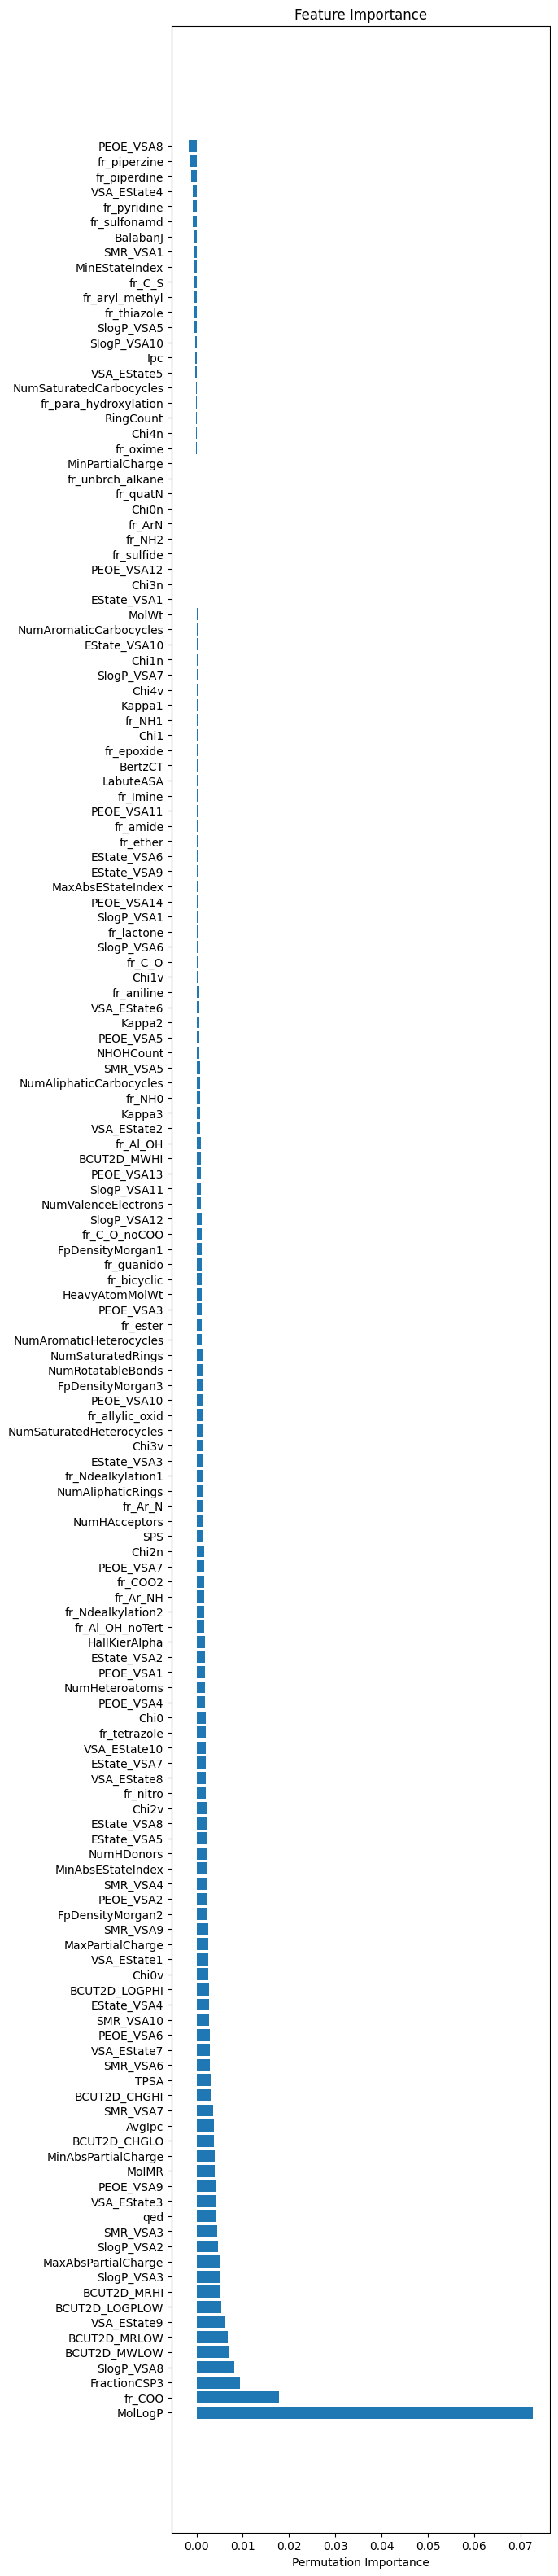

In [28]:
# Get the importance scores for each feature
sorted_idx = result.importances_mean.argsort()

# Because there are too many features, we print and plot only those whose importance is not equal to 0, and thus ignore those whose importance is 0
cols_names_0 = []
importances_mean_0 = []
sorted_idx_0 = []

# Print the feature importances in descending order
for i in sorted_idx[::-1]:

  if result.importances_mean[i] != 0:                 # dont print feature importance that are equal to 0

    print(f"{cols_names[i]}: {result.importances_mean[i]:.3f}")
    cols_names_0.append(cols_names[i])
    importances_mean_0.append(result.importances_mean[i])
    sorted_idx_0.append(i)

# You can also visualize the feature importance using a bar plot
plt.figure(figsize=(6, 40))
plt.barh(
    [cols_names[i] for i in sorted_idx[::-1] if result.importances_mean[i] !=0], #Use the original sorted_idx and cols_names
    [result.importances_mean[i] for i in sorted_idx[::-1] if result.importances_mean[i] !=0],
)
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.show()